# Lyrics detector Challenge

The goal is to leverage my knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, my model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from unidecode import unidecode

from gensim.models import Word2Vec

from sklearn.dummy import DummyClassifier

C:\Users\mvalyashova\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 1. Data Cleaning

The dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [2]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data.head(5)

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...


❓ **Let's have a look at the verse index 18th**

In [3]:
#data.loc[18,:]

In [6]:
pd.options.display.max_colwidth = 300

In [7]:
data.iloc[18, 1]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I\u2005was\u2005down Now them diamonds\u2005for fun like damn Ayy, yeah'

In [8]:
data.nunique()

artist       3
verse     3039
dtype: int64

In [9]:
data.shape

(3975, 2)

❓ **Check if some verses are duplicated and remove them to avoid data leaks between train and test sets**

In [10]:
print('There are ',len(data['verse']) - len(data['verse'].drop_duplicates()), 'duplicate verses.')

There are  936 duplicate verses.


In [11]:
data.drop_duplicates(subset='verse', inplace=True)

In [12]:
data.shape

(3039, 2)

In [13]:
import string

#first I'll clean up punctuation
def punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

data['clean_text'] = data['verse'].apply(punctuation)
data.head(2)

,artist,verse,clean_text
0,Drake,"Ayy, woah Ayy, ayy Yeah",Ayy woah Ayy ayy Yeah
1,Drake,I'm makin' a change today The liquor been takin' the pain away I heard you was givin' your chain away That's kinda like givin' your fame away What's wrong with you? I sit in a box where the owners do A boss is a role that I've grown into I love you to death but I told you the truth,Im makin a change today The liquor been takin the pain away I heard you was givin your chain away Thats kinda like givin your fame away Whats wrong with you I sit in a box where the owners do A boss is a role that Ive grown into I love you to death but I told you the truth


In [14]:
#then lowercase it

def lower_case(text):
        text = text.lower()
        return text
        
data['clean_text'] = data['clean_text'].apply(lower_case)
data.head(2)

,artist,verse,clean_text
0,Drake,"Ayy, woah Ayy, ayy Yeah",ayy woah ayy ayy yeah
1,Drake,I'm makin' a change today The liquor been takin' the pain away I heard you was givin' your chain away That's kinda like givin' your fame away What's wrong with you? I sit in a box where the owners do A boss is a role that I've grown into I love you to death but I told you the truth,im makin a change today the liquor been takin the pain away i heard you was givin your chain away thats kinda like givin your fame away whats wrong with you i sit in a box where the owners do a boss is a role that ive grown into i love you to death but i told you the truth


In [15]:
#and remove potential numbers

def numbers(text):
    return ''.join(word for word in text if not word.isdigit())
    

data['clean_text'] = data['clean_text'].apply(numbers)
data.head(2)

,artist,verse,clean_text
0,Drake,"Ayy, woah Ayy, ayy Yeah",ayy woah ayy ayy yeah
1,Drake,I'm makin' a change today The liquor been takin' the pain away I heard you was givin' your chain away That's kinda like givin' your fame away What's wrong with you? I sit in a box where the owners do A boss is a role that I've grown into I love you to death but I told you the truth,im makin a change today the liquor been takin the pain away i heard you was givin your chain away thats kinda like givin your fame away whats wrong with you i sit in a box where the owners do a boss is a role that ive grown into i love you to death but i told you the truth


In [16]:
from nltk.corpus import stopwords

In [17]:
# and stop words
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import nltk

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mvalyashova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mvalyashova\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
stop_word = set(stopwords.words('english')) 

def stop_words(text):
    word_tokens = word_tokenize(text)
    text = [w for w in word_tokens if not w in stop_word]
    return text

data['clean_text'] = data['clean_text'].apply(stop_words)

In [21]:
data.head(2)

,artist,verse,clean_text
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been takin' the pain away I heard you was givin' your chain away That's kinda like givin' your fame away What's wrong with you? I sit in a box where the owners do A boss is a role that I've grown into I love you to death but I told you the truth,"[im, makin, change, today, liquor, takin, pain, away, heard, givin, chain, away, thats, kinda, like, givin, fame, away, whats, wrong, sit, box, owners, boss, role, ive, grown, love, death, told, truth]"


In [22]:
#another method
#X = data.verse
#import re
#removing accents: X_clean=X.apply(lambda x: unidecode(x))

#lowering text: X_clean=X_clean.apply(lambda x: x.lower())
#regex = re.compile('[^a-z]')

#data['verse']=X_clean.apply(lambda x : regex.sub(' ', x))

In [23]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis

👉 **check the number of unique artist and the number of verses per artist**

In [24]:
data.artist.value_counts()

Drake         1394
Ed Sheeran     867
Kanye West     778
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

I'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [27]:
drake = data[data.artist =='Drake'].clean_text
ed = data[data.artist =='Ed Sheeran'].clean_text
kanye = data[data.artist =='Kanye West'].clean_text

In [28]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [29]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,im,im,im
2,like,need,like
3,know,love,know
4,got,’,get
5,yeah,dont,got
6,dont,like,dont
7,get,know,oh
8,shit,ill,aint
9,’,man,yeah
10,go,oh,cant


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- I compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

In [30]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [31]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

13.95% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
Perform embedding of sentences into numbers by[`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**

In [32]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [33]:
data.rename(columns={'clean_text':'seq'}, inplace=True)
data

,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been takin' the pain away I heard you was givin' your chain away That's kinda like givin' your fame away What's wrong with you? I sit in a box where the owners do A boss is a role that I've grown into I love you to death but I told you the truth,"[im, makin, change, today, liquor, takin, pain, away, heard, givin, chain, away, thats, kinda, like, givin, fame, away, whats, wrong, sit, box, owners, boss, role, ive, grown, love, death, told, truth]"
2,Drake,"I can't just be with you and only you Yeah, I got one, Virgil got one and that there is the only two Man, how many times have I shown improvement? How many nights I been (Woah) Swervin' them potholes Not tryna fuck up the wheels on the road, okay Funny how life goes He thought he was sick, now h...","[cant, yeah, got, one, virgil, got, one, two, man, many, times, shown, improvement, many, nights, woah, swervin, potholes, tryna, fuck, wheels, road, okay, funny, life, goes, thought, sick, wipin, nose, okay, soon, give, em, soul, blow, say, youre, sеlling, soul, okay, want, life, exposеd, wan, ..."
3,Drake,"Well, summer, all I did was rest, okay? And New Year's, all I did was stretch, okay? And Valentine's Day, I had sex, okay? We'll see what's 'bout to happen next Okay? Okay? Okay? We'll see what's 'bout to happen next Okay? Okay? Okay? We'll see what's 'bout to happen, ayy, ayy We'll see what's '...","[well, summer, rest, okay, new, years, stretch, okay, valentines, day, sex, okay, well, see, whats, bout, happen, next, okay, okay, okay, well, see, whats, bout, happen, next, okay, okay, okay, well, see, whats, bout, happen, ayy, ayy, well, see, whats, bout, happen, ayy, well, see, whats, bout,..."
4,Drake,I'm makin' a change today The liquor been takin' the pain away I heard you was givin' your chain away That's kinda like givin' your fame away What's wrong with you? I sit in a box where the owners do A boss is a role that I've grown into I love you to death but I told you the truth I–,"[im, makin, change, today, liquor, takin, pain, away, heard, givin, chain, away, thats, kinda, like, givin, fame, away, whats, wrong, sit, box, owners, boss, role, ive, grown, love, death, told, truth, i–]"
5,Drake,"Ayy, yeah I got one, Laurie got one and that there is the only two Man, how many times have I told you the truth? Man, how many nights I been (Woah) Swervin' them potholes Not tryna fuck up the wheels or fuck up the deals I'm posted in Stockholm It's me, the owls and the twins, it's only the rea...","[ayy, yeah, got, one, laurie, got, one, two, man, many, times, told, truth, man, many, nights, woah, swervin, potholes, tryna, fuck, wheels, fuck, deals, im, posted, stockholm, owls, twins, real, im, movin, way, humble, weezy, handed, still, got, fumbles, im, hot, one, hundo, numero, uno, one, a..."
8,Drake,(Six) Yeah Yeah Yeah,"[six, yeah, yeah, yeah]"
9,Drake,"Leave me out the comments, leave me out the nonsense Speakin' out of context, people need some content Niggas tryna keep up, shit is not a contest Whippin' Benz concept Heaven-sent, God-sent Least that's what my mom says Proof is in the progress, money's not a object Busy than a motherfucker, yo...","[leave, comments, leave, nonsense, speakin, context, people, need, content, niggas, tryna, keep, shit, contest, whippin, benz, concept, heavensent, godsent, least, thats, mom, says, proof, progress, moneys, object, busy, motherfucker, know, job, get, barkin, wrong, tree, know, dogs, get, havent,..."
10,Drake,"Sins, I got sins on my mind And some M's, got a lot of M's on my mind And my friends, yeah, I keep my friends on my mind I'm in love, I'm in love with two girls at one time And they tens, that's why I got ten on my mind I got M's, got a lot of M's on my mind And my friends, yeah, I keep my frien...","[sins, got, sins, mind, ms, got, lot, ms, mind, friends, yeah, keep, friends, mind, im, love, im, love, tw

In [44]:
#data['seq_1'] = data['seq'].apply(tf.keras.preprocessing.text.text_to_word_sequence)

❓ **Let's cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function

C:\Users\mvalyashova\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


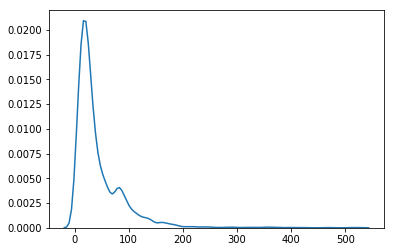

In [36]:
import seaborn as sns

sns.kdeplot([len(verse) for verse in data['seq']])

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [ ]:
data_new = data['seq'].str.slice(stop=299)

In [39]:
# YOUR CODE HERE
for seq in data['seq']:
    seq = seq[:300]

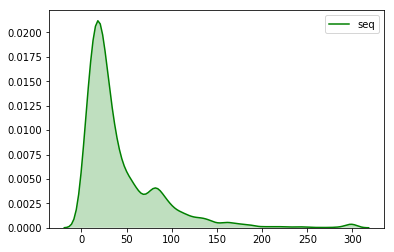

In [40]:
# YOUR CODE HERE
sns.kdeplot(data_new.str.len(),color='green',shade=True)

❓ **Train a `gensim.models.Word2Vec` model ** 
- Embed each word into vectors of dimension `100`
- No word is excluded
- at least 50 epochs to be sure it converges

In [45]:
word2vec = Word2Vec(sentences=data['seq'], vector_size=100, min_count=0, epochs=50)

In [46]:
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [47]:
data['embed'] = embedding(word2vec, data['seq'])
data

,artist,verse,seq,embed
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]","[[-1.7489973, -0.9353843, 3.045907, 0.9955156, -1.635011, -2.6825666, -2.8498957, -0.4187155, -2.2020597, -3.6119843, -1.2225274, -1.0093552, 1.962218, -0.17295271, -0.50632375, -1.619458, 2.9927113, -2.140632, -1.690715, 0.56156003, -2.682254, -1.3792729, 0.7983511, 1.8024687, -1.0167673, 4.902..."
1,Drake,I'm makin' a change today The liquor been takin' the pain away I heard you was givin' your chain away That's kinda like givin' your fame away What's wrong with you? I sit in a box where the owners do A boss is a role that I've grown into I love you to death but I told you the truth,"[im, makin, change, today, liquor, takin, pain, away, heard, givin, chain, away, thats, kinda, like, givin, fame, away, whats, wrong, sit, box, owners, boss, role, ive, grown, love, death, told, truth]","[[0.12188834, -0.43565154, 0.34084073, -0.8060796, 0.19205038, -0.71717757, 1.2678972, 1.3213547, -1.465972, -0.5656701, -0.08051969, 1.2891339, 1.1333524, 0.58948636, -0.4443255, -0.030862061, 1.2154992, 1.5816468, -1.8806332, -0.15031587, -0.2930959, 0.8411025, 1.1549904, -1.1008632, 1.5331802..."
2,Drake,"I can't just be with you and only you Yeah, I got one, Virgil got one and that there is the only two Man, how many times have I shown improvement? How many nights I been (Woah) Swervin' them potholes Not tryna fuck up the wheels on the road, okay Funny how life goes He thought he was sick, now h...","[cant, yeah, got, one, virgil, got, one, two, man, many, times, shown, improvement, many, nights, woah, swervin, potholes, tryna, fuck, wheels, road, okay, funny, life, goes, thought, sick, wipin, nose, okay, soon, give, em, soul, blow, say, youre, sеlling, soul, okay, want, life, exposеd, wan, ...","[[-0.41990274, -1.8070214, 0.13869573, 1.2310233, 4.422825, 1.4408568, 2.1579492, -1.9580184, -4.0459065, 2.6522543, -0.6429453, -0.25377318, 2.5535347, -1.0946152, 0.044761296, -1.0322977, 1.8113909, -0.590022, 0.0065212916, -2.8506484, 0.783814, 0.19879872, 0.29670212, 0.061386555, -2.666102, ..."
3,Drake,"Well, summer, all I did was rest, okay? And New Year's, all I did was stretch, okay? And Valentine's Day, I had sex, okay? We'll see what's 'bout to happen next Okay? Okay? Okay? We'll see what's 'bout to happen next Okay? Okay? Okay? We'll see what's 'bout to happen, ayy, ayy We'll see what's '...","[well, summer, rest, okay, new, years, stretch, okay, valentines, day, sex, okay, well, see, whats, bout, happen, next, okay, okay, okay, well, see, whats, bout, happen, next, okay, okay, okay, well, see, whats, bout, happen, ayy, ayy, well, see, whats, bout, happen, ayy, well, see, whats, bout,...","[[-1.9030457, 0.06557344, 2.8034348, 0.8055785, -0.09644601, -1.9527825, -0.807977, 0.13190414, -2.2703588, 0.44500765, -1.894376, 0.08083263, -0.032572586, -0.7127829, 0.97846824, 0.55727345, 1.6884733, -0.64981437, 1.291722, -3.1601233, -1.2796681, 2.426292, -0.42562303, -0.5862727, 1.9018502,..."
4,Drake,I'm makin' a change today The liquor been takin' the pain away I heard you was givin' your chain away That's kinda like givin' your fame away What's wrong with you? I sit in a box where the owners do A boss is a role that I've grown into I love you to death but I told you the truth I–,"[im, makin, change, today, liquor, takin, pain, away, heard, givin, chain, away, thats, kinda, like, givin, fame, away, whats, wrong, sit, box, owners, boss, role, ive, grown, love, death, told, truth, i–]","[[0.12188834, -0.43565154, 0.34084073, -0.8060796, 0.19205038, -0.71717757, 1.2678972, 1.3213547, -1.465972, -0.5656701, -0.08051969, 1.2891339, 1.1333524, 0.58948636, -0.4443255, -0.030862061, 1.2154992, 1.5816468, -1.8806332, -0.15031587, -0.2930959, 0.8411025, 1.1549904, -1.1008632, 1.5331802..."
5,Drake,"Ayy, yeah I got one, Laurie got one and that there is the only two Man, how many times have I told you the truth? Man, how many nights I been (Woah) Swervin' them potholes 

In [50]:
#and more rapid way
#for index, row in data.iterrows():
    #vector_list = []
    #for word in row['seq']:
        #vector_list.append(word2vec.wv[word])
    #row['embed1'] = vector_list

In [51]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create a numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [52]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = pad_sequences(data['embed'], dtype='float32', padding='post', maxlen=300)

In [53]:
X.shape

(3039, 300, 100)

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [54]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
y_sparse = cat_encoder.fit_transform(data[['artist']])
y = y_sparse.toarray()

y.shape

(3039, 3)

👉 Train/test split the dataset

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Building the (X,Y) training sets

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

❓ **store the baseline accuracy to beat as `score_baseline`**

In [60]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)

score_baseline = dummy_clf.score(X_train, y_train)
score_baseline

0.16947758124228712

In [58]:
column_sums = y_train.sum(axis=0)

score_baseline = np.max(column_sums) / len(X_train)
score_baseline

0.46359522830111066

In [59]:

column_sums

array([1127.,  705.,  599.])

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Don't forget to take care of fake "zeros" added during preprocessing

In [61]:
def init_model():
    model = Sequential()
    model.add(Masking(mask_value=0, input_shape=(300, 100)))
    model.add(LSTM(units=20, activation = 'tanh'))
    model.add(Dense(units=100, activation='relu'))
    model.add(Dropout(rate = 0.5))
    
    model.add(Dense(units=3, activation='sigmoid'))
    
    model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics = 'accuracy')
    return model

In [63]:
model = init_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 300, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                9680      
_________________________________________________________________
dense (Dense)                (None, 100)               2100      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 12,083
Trainable params: 12,083
Non-trainable params: 0
_________________________________________________________________


❓ **Train the `model` on the `(X_train, y_train)` training set**
- Adapt the learning rate of the optimizer if convergence is too slow/fast
- Make sure the model does not overfit with appropriate control techniques

In [67]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                   batch_size = 16,
                   epochs = 1000,
                   callbacks=es,
                   validation_split=0.3)

Epoch 1/1000
107/107 [==============================] - 41s 387ms/step - loss: 0.3032 - accuracy: 0.8907 - val_loss: 1.0816 - val_accuracy: 0.6466
Epoch 2/1000
107/107 [==============================] - 42s 395ms/step - loss: 0.2428 - accuracy: 0.9089 - val_loss: 1.1727 - val_accuracy: 0.6616
Epoch 3/1000
107/107 [==============================] - 41s 385ms/step - loss: 0.2069 - accuracy: 0.9259 - val_loss: 1.2589 - val_accuracy: 0.6507
Epoch 4/1000
107/107 [==============================] - 39s 369ms/step - loss: 0.1508 - accuracy: 0.9524 - val_loss: 1.3498 - val_accuracy: 0.6466
Epoch 5/1000
107/107 [==============================] - 42s 392ms/step - loss: 0.1264 - accuracy: 0.9594 - val_loss: 1.4692 - val_accuracy: 0.6726
Epoch 6/1000
107/107 [==============================] - 40s 377ms/step - loss: 0.0964 - accuracy: 0.9677 - val_loss: 1.5363 - val_accuracy: 0.6726


❓ **Plot the training and validation losses through training**

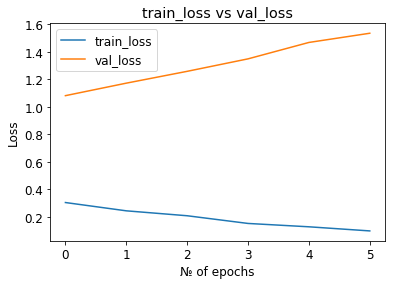

In [68]:
plt.rc('font', size=12)

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.title("train_loss vs val_loss")
plt.xlabel("№ of epochs")
plt.ylabel("Loss")

# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Save the accuracy on test set as `score_test`**

In [69]:
'Model is overfitting despite optimization of the learning rate and the dropout layer. Have no time to adjust it properly.'
score_test = model.evaluate(X_test, y_test)[1]
score_test

19/19 [==============================] - 4s 88ms/step - loss: 1.1834 - accuracy: 0.6299


0.6299341917037964

In [70]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()